In [1]:
import datasets
import requests
from datasets import load_dataset
import numpy as np
from huggingface_hub import hf_hub_download
import openai
from tqdm import tqdm
from SPARQLWrapper import SPARQLWrapper, JSON

In [2]:
dataset2 = load_dataset('relbert/t_rex')

In [3]:
openwebtext_entity_map = np.load("openwebtext_entity_map.npz", allow_pickle=True)

In [4]:
def entity2dbpediaID(entity_name):
    e2 = '_'.join(entity_name.split(' '))
    dbpedia_id2 = f'http://dbpedia.org/resource/{e2}'
    return dbpedia_id2

In [9]:
import time

start = time.time()
print(dataset2["train"][6]['head'])
end = time.time()
print(end - start)

Victoria Falls Bridge
0.0003693103790283203


In [10]:
start = time.time()
print(entity2dbpediaID("Victoria Falls Bridge"))
end = time.time()
print(end - start)

http://dbpedia.org/resource/Victoria_Falls_Bridge
0.000102996826171875


In [11]:
start = time.time()
print(openwebtext_entity_map["http://dbpedia.org/resource/Victoria_Falls_Bridge"])
end = time.time()
print(end - start)

[6285824 1780003  114595 1413862 5825641  941066 3211786 6694187 5691823
  614128 3665074 7463415]
0.030974864959716797


In [8]:

num_intersect_mentions_all = np.zeros(20)
num_errors = 0
for idx in tqdm(range(20)):
    num_intersect_mentions = 0
    try:
        head_mentions = openwebtext_entity_map[entity2dbpediaID(dataset2["train"][idx]['head'])]
        tail_mentions = openwebtext_entity_map[entity2dbpediaID(dataset2["train"][idx]['tail'])]
        num_intersect_mentions = len(set(head_mentions).intersection(set(tail_mentions)))
    except:
        num_errors += 1
        num_intersect_mentions = -1
    num_intersect_mentions_all[idx] = num_intersect_mentions

100%|██████████| 20/20 [00:01<00:00, 18.67it/s]


In [9]:
num_intersect_mentions_all

array([103.,  -1.,  -1.,  -1.,   9.,  -1.,  -1.,  -1.,  -1.,   1.,   0.,
         0.,   3.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.])

In [11]:
def get_num_intersection_mentions(idx):
    num_intersect_mentions = 0
    try:
        head_mentions = openwebtext_entity_map[entity2dbpediaID(dataset2["train"][idx]['head'])]
        tail_mentions = openwebtext_entity_map[entity2dbpediaID(dataset2["train"][idx]['tail'])]
        num_intersect_mentions = len(set(head_mentions).intersection(set(tail_mentions)))
    except:
        num_intersect_mentions = -1
    return num_intersect_mentions

In [13]:
from multiprocessing import Pool
with Pool() as pool:
    num_intersection_mentions_all = list(tqdm(pool.imap(get_num_intersection_mentions, [i for i in range(20)]), total=(20)))

    # = list(tqdm(pool.imap(get_dbpedia_id, entities), total=len(entities)))

100%|██████████| 20/20 [00:00<00:00, 35.34it/s]


In [14]:
num_intersection_mentions_all

[103, -1, -1, -1, 9, -1, -1, -1, -1, 1, 0, 0, 3, -1, -1, -1, -1, -1, -1, -1]

In [34]:
tail_mentions

array([1707528, 7236756, 2452340], dtype=int32)

In [35]:
head_mentions

array([3826034], dtype=int32)

In [26]:
openwebtext_entity_map[entity2dbpediaID(dataset2["train"]['head'][10])]

array([3826034], dtype=int32)

In [48]:
openwebtext_entity_map.files

['http://dbpedia.org/resource/Internal_Revenue_Service',
 'http://dbpedia.org/resource/Passport',
 'http://dbpedia.org/resource/Chicago',
 'http://dbpedia.org/resource/Grand_juries_in_the_United_States',
 'http://dbpedia.org/resource/New_York_City',
 'http://dbpedia.org/resource/Cleveland',
 'http://dbpedia.org/resource/Ferguson,_Missouri',
 'http://dbpedia.org/resource/Getty_Images',
 'http://dbpedia.org/resource/United_States_Congress',
 'http://dbpedia.org/resource/Bobby_Scott_(musician)',
 'http://dbpedia.org/resource/George_Washington',
 'http://dbpedia.org/resource/Act_of_Congress',
 'http://dbpedia.org/resource/Walter_Scott',
 'http://dbpedia.org/resource/Authorization_bill',
 'http://dbpedia.org/resource/Shooting_of_Michael_Brown',
 'http://dbpedia.org/resource/Killing_of_Eric_Garner',
 'http://dbpedia.org/resource/Crowdsourcing',
 'http://dbpedia.org/resource/Gawker',
 'http://dbpedia.org/resource/Sport',
 'http://dbpedia.org/resource/Deadspin',
 'http://dbpedia.org/resource/C

In [15]:
def get_dbpedia_id(entity_name):
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    query = f"""
    SELECT ?s WHERE {{
      ?s rdfs:label "{entity_name}"@en.
    }}
    """
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    for result in results["results"]["bindings"]:
        return result["s"]["value"]
    return ""

#batched call to above

# def get_dbpedia_id(entity_name):
#     endpoint = "http://dbpedia.org/sparql"
#     query = f"""
#     PREFIX dbo: <http://dbpedia.org/ontology/>
#     SELECT ?s WHERE {{
#       ?s rdfs:label "{entity_name}"@en .
#     }}
#     """
#     headers = {"Accept": "application/json"}
#     params = {"query": query, "format": "json"}
#     response = requests.get(endpoint, headers=headers, params=params)
#     if response.status_code == 200:
#         data = response.json()
#         results = data["results"]["bindings"]
#         if results:
#             return results[0]["s"]["value"]
#         else:
#             return None
#     else:
#         print(f"Error: {response.status_code}")
#         return None

entity_name ='Neverwinter Nights 2' # "IRS"
for entity_name in tqdm(names):
  e2 = '_'.join(entity_name.split(' '))
  dbpedia_id2 = f'http://dbpedia.org/resource/{e2}'
  dbpedia_id = get_dbpedia_id(entity_name)
  # print(entity_name, dbpedia_id, dbpedia_id2)
  if dbpedia_id != dbpedia_id2:
    print(f'Error: {entity_name} {dbpedia_id} {dbpedia_id2}')
    # raise Exception('Error')

  0%|          | 21/1274264 [00:19<333:43:38,  1.06it/s]

Error: Ivrea http://dbpedia.org/resource/Category:Ivrea http://dbpedia.org/resource/Ivrea


  0%|          | 23/1274264 [00:21<331:02:10,  1.07it/s]

Error: miscellaneous auxiliary  http://dbpedia.org/resource/miscellaneous_auxiliary


  0%|          | 32/1274264 [00:34<442:33:21,  1.25s/it]

Error: Pope Benedict XIV http://dbpedia.org/resource/Category:Pope_Benedict_XIV http://dbpedia.org/resource/Pope_Benedict_XIV


  0%|          | 41/1274264 [00:43<332:46:19,  1.06it/s]

Error: Eulophia http://dbpedia.org/resource/Category:Eulophia http://dbpedia.org/resource/Eulophia


  0%|          | 46/1274264 [00:47<344:41:22,  1.03it/s]

Error: Serbian Orthodox Church http://dbpedia.org/resource/Category:Serbian_Orthodox_Church http://dbpedia.org/resource/Serbian_Orthodox_Church


  0%|          | 49/1274264 [00:51<359:35:24,  1.02s/it]

Error: Shane Warne http://dbpedia.org/resource/Category:Shane_Warne http://dbpedia.org/resource/Shane_Warne


  0%|          | 50/1274264 [00:52<350:49:46,  1.01it/s]

Error: Rafael Advanced Defense Systems http://dbpedia.org/resource/Category:Rafael_Advanced_Defense_Systems http://dbpedia.org/resource/Rafael_Advanced_Defense_Systems


  0%|          | 65/1274264 [01:09<346:08:47,  1.02it/s]

Error: Neighbours http://dbpedia.org/resource/Category:Neighbours http://dbpedia.org/resource/Neighbours


  0%|          | 70/1274264 [01:14<334:07:14,  1.06it/s]

Error: Watchet http://dbpedia.org/resource/Category:Watchet http://dbpedia.org/resource/Watchet


  0%|          | 87/1274264 [01:36<391:31:30,  1.11s/it]


KeyboardInterrupt: 

In [17]:
for a in openwebtext_entity_map.files:
    if "Category:" in a:
        print(a)

http://dbpedia.org/resource/Category:Fusion_music_genres
http://dbpedia.org/resource/Category:Terrorism_in_Iraq


In [49]:
url = "http://lookup.dbpedia.org/api/search/PrefixSearch"
headers = {
    "Accept": "application/json"
}
params = {
    "QueryString": entity_name,
    "format": "json"
}
response = requests.get(url, headers=headers, params=params)
data = response.json()

In [51]:
# response.__dict__
data["results"][0]["uri"]

KeyError: 'results'

In [27]:
dataset2 = load_dataset('relbert/t_rex')

In [31]:
dataset2["train"][0]["head"]

'Neverwinter Nights 2'

In [60]:
num_entities_not_dbpedia = 0
for i in (range(100)):
    idx = np.random.randint(0, len(dataset2["train"]))
    dbpedia_id = get_dbpedia_id(dataset2["train"][idx]["head"])
    print(dbpedia_id)
    if dbpedia_id is None:
        num_entities_not_dbpedia += 1
        print(dataset2["train"][idx]["head"])
    elif dbpedia_id not in openwebtext_entity_map.files:
        print("ABOVE NOT IN KEYS")

http://dbpedia.org/resource/Erich_Mix
ABOVE NOT IN KEYS
http://dbpedia.org/resource/John_Bagot_Glubb
http://dbpedia.org/resource/Sevilla
ABOVE NOT IN KEYS
http://dbpedia.org/resource/New_London_County
ABOVE NOT IN KEYS
http://dbpedia.org/resource/Category:Philippines
ABOVE NOT IN KEYS
http://dbpedia.org/resource/Sarpsborg
http://dbpedia.org/resource/Rukwa
ABOVE NOT IN KEYS
None
natural language processing
http://dbpedia.org/resource/Dylan_McGeouch
http://dbpedia.org/resource/Evers_Burns
ABOVE NOT IN KEYS
http://dbpedia.org/resource/Graham_Swift
http://dbpedia.org/resource/Category:Interstate_30
ABOVE NOT IN KEYS
http://dbpedia.org/resource/Musselburgh
http://dbpedia.org/resource/Darren_Shaw
ABOVE NOT IN KEYS
http://dbpedia.org/resource/Syrian_Civil_War
ABOVE NOT IN KEYS
http://dbpedia.org/resource/Rama_Prabha
ABOVE NOT IN KEYS
http://dbpedia.org/resource/Au_Wai_Lun
ABOVE NOT IN KEYS
http://dbpedia.org/resource/High_School_Musical
http://dbpedia.org/resource/Newark
ABOVE NOT IN KEYS
htt

KeyboardInterrupt: 

In [62]:
len(dataset2["train"])

1274264

In [61]:

for a in openwebtext_entity_map.files:
    if "Erich" in a and "Mix" in a:
        print(a)
        

In [63]:
len(openwebtext_entity_map.files)

842605

In [69]:
from multiprocessing import Pool
with Pool() as pool:
    results_head = pool.map(get_dbpedia_id, [dataset2["train"][i]["head"] for i in range(len(dataset2["train"]))])
    results_tail = pool.map(get_dbpedia_id, [dataset2["train"][i]["tail"] for i in range(len(dataset2["train"]))])

In [73]:
dataset2["train"][0]

{'relation': 'P178',
 'head': 'Neverwinter Nights 2',
 'tail': 'Obsidian Entertainment',
 'title': 'Neverwinter Nights 2: Storm of Zehir',
 'text': "Neverwinter Nights 2: Storm of Zehir is an expansion pack for the role-playing video game Neverwinter Nights 2, developed by Obsidian Entertainment and published by Atari. It was released in late 2008 in North America, Europe, and Australia. Like previous entries in the Neverwinter Nights series, Storm of Zehir is based on the paper and pencil fantasy role-playing game Dungeons & Dragons, and uses the game's 3.5 edition ruleset. Storm of Zehir was inspired by older video games like the Baldur's Gate and Icewind Dale franchises. The storyline foreshadows the events of the fourth edition of Dungeons & Dragons and follows the adventures of a group of merchants in the Samarach and Sword Coast areas of the Forgotten Realms campaign setting. Storm of Zehir received mixed reviews from critics. Reviewers were pleased with new features introduced i

In [74]:
results

['http://dbpedia.org/resource/Neverwinter_Nights_2',
 'http://dbpedia.org/resource/Minuteman_III',
 'http://dbpedia.org/resource/Daniel_Ferreyra',
 'http://dbpedia.org/resource/Royal_Engineers',
 'http://dbpedia.org/resource/Rocky_IV',
 'http://dbpedia.org/resource/The_Garden_of_Eden_with_the_Fall_of_Man',
 'http://dbpedia.org/resource/Victoria_Falls_Bridge',
 'http://dbpedia.org/resource/Gila_River',
 'http://dbpedia.org/resource/Bowe_Bergdahl',
 'http://dbpedia.org/resource/Mega_Man_5',
 'http://dbpedia.org/resource/The_Last_Grenade',
 'http://dbpedia.org/resource/Tommy_Dunderdale',
 'http://dbpedia.org/resource/Some_Came_Running',
 'http://dbpedia.org/resource/Jean_Henri_van_Swinden',
 'http://dbpedia.org/resource/Masato_Yoshihara',
 'http://dbpedia.org/resource/Delvin',
 'http://dbpedia.org/resource/Colt_38_Special_Squad',
 'http://dbpedia.org/resource/Cincinnati_Art_Museum',
 'http://dbpedia.org/resource/Tweaker',
 'http://dbpedia.org/resource/Alekhine',
 'http://dbpedia.org/resou

In [71]:
[dataset2["train"][i]["head"] for i in range(100)]

['Neverwinter Nights 2',
 'Minuteman III',
 'Daniel Ferreyra',
 'Royal Engineers',
 'Rocky IV',
 'The Garden of Eden with the Fall of Man',
 'Victoria Falls Bridge',
 'Gila River',
 'Bowe Bergdahl',
 'Mega Man 5',
 'The Last Grenade',
 'Tommy Dunderdale',
 'Some Came Running',
 'Jean Henri van Swinden',
 'Masato Yoshihara',
 'Delvin',
 'Colt 38 Special Squad',
 'Cincinnati Art Museum',
 'Tweaker',
 'Alekhine',
 'Ivrea',
 'Pratt County',
 'miscellaneous auxiliary',
 'NASDAQ',
 'Ponte Sisto',
 'Irina Shlemova',
 'Gap',
 'Prachinburi Province',
 'Rilke',
 'Asa Hall',
 'Flamstead',
 'Pope Benedict XIV',
 'Jacob Bruce',
 'Liam Ridgewell',
 'British Isles',
 'Derek Brazil',
 'Steve Williamson',
 'Lord Ganesh',
 'A Beautiful Lie',
 'Man and His Soul',
 'Eulophia',
 'The Purple Rose of Cairo',
 'Dehaj District',
 'Aloysius Varsi',
 'Brooke Knows Best',
 'Serbian Orthodox Church',
 'La Romareda',
 'Giovanni Bia',
 'Shane Warne',
 'Rafael Advanced Defense Systems',
 'Nadjim Abdou',
 'Beliatore',

In [70]:
word_relations = []
relations_all = dataset2["train"]["relation"]
for i in tqdm(range(len(relations_all))):
    if relations_all[i][0] != "P":
        word_relations.append(relations_all[i])

100%|██████████| 1274264/1274264 [00:00<00:00, 3926483.34it/s]


In [72]:
len(word_relations)

102718

In [74]:
(set(word_relations))

{'[Academic Subject] studies [Topic]',
 '[Aircraft] makes the maiden flight on [Date]',
 '[Airline] is in [Airline Alliance]',
 '[Army] has [Fleet]',
 '[Army] is based in [Location]',
 '[Art Work] follows after [Art Work]',
 '[Art Work] is a painting of [Person]',
 '[Art Work] is a translation of [Art Work]',
 '[Art Work] is adapted from [Art Work]',
 '[Art Work] is directed by [Person]',
 '[Art Work] is painted by [Person]',
 '[Art Work] is published in [Magazine]',
 '[Art Work] is published on [Date]',
 '[Art Work] is sculpted by [Person]',
 '[Art Work] is written by [Person]',
 '[Artifact] has [Engine]',
 '[Artifact] is a patron saint of [Country]',
 '[Artifact] is a type of [Type]',
 '[Artifact] is a version of [Artifact]',
 '[Artifact] is built on [Date]',
 '[Artifact] is discovered by [Person]',
 '[Artifact] is formation of [Army]',
 '[Artifact] is formed from [Artifact]',
 '[Artifact] is influenced by [Artifact]',
 '[Artifact] is listed in [List]',
 '[Artifact] is maintained by 

In [ ]:
import pickle

with open('trex_head_dbpedia_ids', 'wb') as fp:
    pickle.dump(results_head, fp)

with open('trex_tail_dbpedia_ids', 'wb') as fp:
    pickle.dump(results_tail, fp)

In [15]:
trex_num_mentions = np.load("trex_num_mentions.npy")

In [27]:
(trex_num_mentions!=-1).sum()

191699

(array([72455., 17904., 16062.,  7496.,  8264.,  4360.,  5414.,  3110.,
         3895.,  3248.]),
 array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5, 25. ]),
 <BarContainer object of 10 artists>)

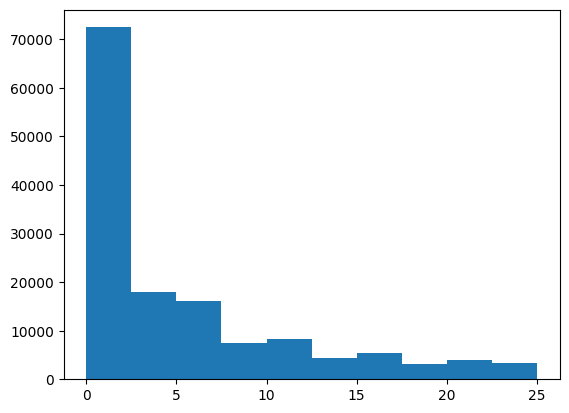

In [26]:
import matplotlib.pyplot as plt
plt.hist(trex_num_mentions, range=(0, 25))

In [60]:

dataset_orig = load_dataset('lama')
train_idxs = np.load("lama_train_idxs2.npy")

train_data = dataset_orig["train"].select(train_idxs)



In [64]:
len(list(set(train_data['predicate_id'])))

37

In [82]:
# not in training dataset

relations_all = dataset2["train"]["relation"]

import json
with open('trex_relations2questions.json') as json_file:
    questions_dict = json.load(json_file)

def get_wikidata_property_label(property_id):
    url = "https://www.wikidata.org/w/api.php"
    params = {
        "action": "wbgetentities",
        "ids": property_id,
        "props": "labels",
        "languages": "en",
        "format": "json",
    }
    response = requests.get(url, params=params)
    data = response.json()
    label = data['entities'][property_id]['labels']['en']['value']
    return label

In [86]:
len(questions_dict.keys())

544

In [94]:
len(questions_dict2.keys())

with open('trex_relations2questions2.json', 'w') as fp:
    json.dump(questions_dict2, fp)

In [95]:
with open('trex_relations2questions2.json', 'rb') as fp:
    questions_dict3 = json.load(fp)

In [93]:
len(questions_dict.keys())

544

In [89]:
questions_dict

{'surface played on': 'What kind of surface is [X] played on?',
 'honorific suffix': 'What is the honorific suffix of [X]?',
 'after a work by': 'Who is the original author of the work that [X] is based on?',
 'physically interacts with': 'What does [X] physically interact with?',
 'designed by': 'Who was [X] designed by?',
 'inception': 'When was the inception of [X]?',
 'capital of': 'What is the capital of [X]?',
 'record held': 'What record does [X] hold?',
 'team captain': 'Who is the team captain of [X]?',
 'main subject': 'What is the main subject of [X]?',
 'defendant': 'Who was the defendant in the [X]?',
 'voice actor': 'Who is the voice actor in [X]?',
 'torch lit by': 'Who was the torch lit by in [X]?',
 'antiparticle': 'What is the antiparticle of [X]?',
 'protocol': 'What protocol does the [X] use?',
 'Roman praenomen': 'What is the Roman praenomen of [X]?',
 'applies to jurisdiction': 'What jurisdiction does [X] apply to?',
 'astronaut mission': 'What was the astronaut m

In [97]:


# filters: in relations to questions dict

in_questions_dict = np.zeros(len(relations_all))
for i in tqdm(range(len(relations_all))):
    if relations_all[i] in questions_dict3.keys():
        in_questions_dict[i]=1


  0%|          | 0/1274264 [00:00<?, ?it/s]

100%|██████████| 1274264/1274264 [00:00<00:00, 2511078.88it/s]


In [102]:
# filters: not in training relations

not_in_training_relations = np.zeros(len(relations_all))
training_relations = list(set(train_data['predicate_id']))

for i in tqdm(range(len(relations_all))):
    if relations_all[i] not in training_relations:
        not_in_training_relations[i]=1

100%|██████████| 1274264/1274264 [00:00<00:00, 2000530.24it/s]


In [103]:
not_in_training_relations.sum()/len(not_in_training_relations)

0.49460629822391594

In [83]:
get_wikidata_property_label(relations_all[5])

'based on'

In [110]:
trex_ood_idxs_0 = (np.where( (trex_num_mentions==0)*(not_in_training_relations==1)*(in_questions_dict==1))[0])

np.save("trex_ood_idxs_0.npy", trex_ood_idxs_0)

In [113]:


trex_ood_idxs_1 = (np.where((trex_num_mentions==1)*(not_in_training_relations==1)*(in_questions_dict==1))[0])
np.save("trex_ood_idxs_1.npy", trex_ood_idxs_1)
len(trex_ood_idxs_1)

9682

In [114]:

trex_ood_idxs_2 = (np.where((trex_num_mentions==2)*(not_in_training_relations==1)*(in_questions_dict==1))[0])
np.save("trex_ood_idxs_2.npy", trex_ood_idxs_2)
len(trex_ood_idxs_2)

5950

In [115]:
trex_ood_idxs_2_4 = (np.where((trex_num_mentions<=4)*(trex_num_mentions>2)*(not_in_training_relations==1)*(in_questions_dict==1))[0])
np.save("trex_ood_idxs_2_4.npy", trex_ood_idxs_2_4)
len(trex_ood_idxs_2_4)

7727

In [116]:
# len(np.where(np.logical_and(trex_num_mentions<=8, trex_num_mentions>4))[0])

trex_ood_idxs_4_8 = (np.where((trex_num_mentions<=8)*(trex_num_mentions>4)*(not_in_training_relations==1)*(in_questions_dict==1))[0])
np.save("trex_ood_idxs_4_8.npy", trex_ood_idxs_4_8)
len(trex_ood_idxs_4_8)

8850

In [117]:
# len(np.where(np.logical_and(trex_num_mentions<=16, trex_num_mentions>8))[0])

trex_ood_idxs_8_16 = (np.where((trex_num_mentions<=16)*(trex_num_mentions>8)*(not_in_training_relations==1)*(in_questions_dict==1))[0])
np.save("trex_ood_idxs_8_16.npy", trex_ood_idxs_8_16)
len(trex_ood_idxs_8_16)

8581

In [118]:
# len(np.where(np.logical_and(trex_num_mentions<=32, trex_num_mentions>16))[0])

trex_ood_idxs_16_32 = (np.where((trex_num_mentions<=32)*(trex_num_mentions>16)*(not_in_training_relations==1)*(in_questions_dict==1))[0])
np.save("trex_ood_idxs_16_32.npy", trex_ood_idxs_16_32)
len(trex_ood_idxs_16_32)

7808

In [119]:
# len(np.where(np.logical_and(trex_num_mentions<=64, trex_num_mentions>32))[0])

trex_ood_idxs_32_64 = (np.where((trex_num_mentions<=64)*(trex_num_mentions>32)*(not_in_training_relations==1)*(in_questions_dict==1))[0])
np.save("trex_ood_idxs_32_64.npy", trex_ood_idxs_32_64)
len(trex_ood_idxs_32_64)

6118

In [120]:
# len(np.where(np.logical_and(trex_num_mentions<=128, trex_num_mentions>64))[0])

trex_ood_idxs_64_128 = (np.where((trex_num_mentions<=128)*(trex_num_mentions>64)*(not_in_training_relations==1)*(in_questions_dict==1))[0])
np.save("trex_ood_idxs_64_128.npy", trex_ood_idxs_64_128)
len(trex_ood_idxs_64_128)

4355

In [121]:
len(np.where((trex_num_mentions>128))[0])

trex_ood_idxs_128 = (np.where((trex_num_mentions>128)*(not_in_training_relations==1)*(in_questions_dict==1))[0])
np.save("trex_ood_idxs_128+.npy", trex_ood_idxs_128)
len(trex_ood_idxs_128)

6683